# Baseline Fraud Model Training

This notebook trains a baseline fraud detection model using
engineered transaction features and evaluates performance
with fraud-appropriate metrics.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt


In [6]:
import os

# Get the current working directory
os.getcwd()

'c:\\Users\\ozdil\\Downloads\\fraud\\LLM-Enhanced-Fraud-Detection-System-for-Consumer-Financial-Transactions\\notebooks'

In [13]:
df = pd.read_parquet("transactions_features.parquet")

print(df.shape)
df.head()


(118108, 446)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card_amt_mean,card_amt_std,amt_zscore,card_txn_count_day,card_amt_sum_day,time_since_prev_txn,missing_identity_count,has_identity_info,high_amount_flag,night_transaction_flag
0,3021401,0,850730,23.203,C,1007,555.0,135.0,mastercard,224.0,...,39.183500,22.599840,-0.707107,1,23.203,-1.0,19,1,0,0
1,3226241,0,5651177,55.164,C,1007,555.0,135.0,mastercard,224.0,...,39.183500,22.599840,0.707107,1,55.164,4800447.0,19,1,0,0
2,3232272,0,5845013,57.950,W,1008,555.0,150.0,visa,226.0,...,57.950000,NaN,NaN,1,57.950,-1.0,38,0,0,0
3,3069808,0,1784656,482.350,W,1012,479.0,150.0,visa,162.0,...,272.433333,181.948841,1.153713,1,482.350,-1.0,38,0,0,0
4,3098185,0,2166984,175.000,R,1012,479.0,150.0,visa,162.0,...,272.433333,181.948841,-0.535499,1,175.000,382328.0,10,1,0,1


In [14]:
feature_cols = [
    "amt_zscore",
    "card_txn_count_day",
    "card_amt_sum_day",
    "time_since_prev_txn",
    "missing_identity_count",
    "high_amount_flag",
    "night_transaction_flag"
]

X = df[feature_cols]
y = df["isFraud"]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [18]:
from sklearn.impute import SimpleImputer

# 1️⃣ Impute NaNs
imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 2️⃣ Scale
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


In [19]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)


c:\Users\ozdil\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [20]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


In [21]:
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9790    0.7476    0.8478     22774
           1     0.0774    0.5684    0.1362       848

    accuracy                         0.7411     23622
   macro avg     0.5282    0.6580    0.4920     23622
weighted avg     0.9466    0.7411    0.8222     23622



In [22]:
ap = average_precision_score(y_test, y_prob)
print(f"Average Precision (PR-AUC): {ap:.4f}")


Average Precision (PR-AUC): 0.0762


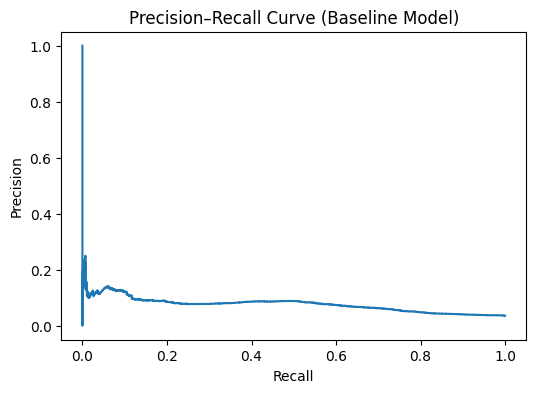

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline Model)")
plt.show()


In [26]:
thresholds = np.linspace(0.01, 0.5, 50)

results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    report = classification_report(
        y_test,
        y_pred_t,
        output_dict=True,
        zero_division=0
    )

    results.append({
        "threshold": t,
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"]
    })

threshold_df = pd.DataFrame(results)
threshold_df.head()


,threshold,precision,recall
0,0.01,0.035899,1.0
1,0.02,0.035899,1.0
2,0.03,0.035899,1.0
3,0.04,0.035899,1.0
4,0.05,0.035899,1.0


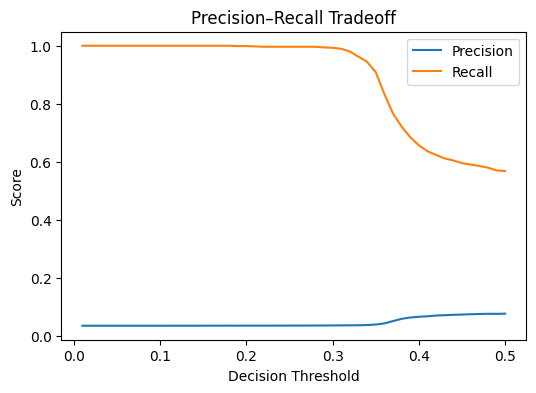

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall Tradeoff")
plt.legend()
plt.show()


In [24]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[17025,  5749],
       [  366,   482]])

In [25]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": model.coef_[0]
}).sort_values("coefficient", ascending=False)

coef_df


,feature,coefficient
0,amt_zscore,0.169011
5,high_amount_flag,0.031802
6,night_transaction_flag,0.008776
2,card_amt_sum_day,-0.002603
3,time_since_prev_txn,-0.107089
1,card_txn_count_day,-0.136209
4,missing_identity_count,-0.616636


### Baseline Model Summary

A cost-aware logistic regression model was trained as a transparent baseline.
Despite its simplicity, the model captures key fraud signals such as
transaction velocity, abnormal spending behavior, and missing identity information.

Precision–Recall AUC is used as the primary evaluation metric due to extreme
class imbalance in fraud detection.
